### Submitted by : 
# Rohit Verma
# Rossmann's Store Sales

**Rossmann is Germany's second-largest drug store chain, with over 3,600 stores in Europe.**

**    Id** - an Id that represents a (Store, Date) duple within the test set
    
**    Store** - a unique Id for each store
    
**    Sales** - the turnover for any given day (this is what you are predicting)
    
**    Customers** - the number of customers on a given day
    
**    Open** - an indicator for whether the store was open: 0 = closed, 1 = open
    
**    StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
    Note    that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, 
    c =   Christmas, 0 = None
    
**    SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
    
**    StoreType** - differentiates between 4 different store models: a, b, c, d
    
**    Assortment** - describes an assortment level: a = basic, b = extra, c = extended
    
**    CompetitionDistance** - distance in meters to the nearest competitor store
    
**    CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
    
**    Promo** - indicates whether a store is running a promo on that day
    
**    Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating,
     1 = store is participating
     
**    Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
    
**    PromoInterval**-describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.
    E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store 

In [13]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
import math 
# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

import keras
from keras import backend as K

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving rossmann.csv to rossmann (1).csv


In [3]:
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded['rossmann.csv'].decode('utf-8')))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
new = df.copy()

In [5]:
 from google.colab import files
uploaded = files.upload()

Saving store.csv to store (2).csv


In [0]:
store = pd.read_csv(io.StringIO(uploaded['store.csv'].decode('utf-8')))

In [7]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (2).csv


In [0]:
test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))

In [9]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [10]:
df.Date.unique()

array(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
       '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
       '2015-07-23', '2015-07-22', '2015-07-21', '2015-07-20',
       '2015-07-19', '2015-07-18', '2015-07-17', '2015-07-16',
       '2015-07-15', '2015-07-14', '2015-07-13', '2015-07-12',
       '2015-07-11', '2015-07-10', '2015-07-09', '2015-07-08',
       '2015-07-07', '2015-07-06', '2015-07-05', '2015-07-04',
       '2015-07-03', '2015-07-02', '2015-07-01', '2015-06-30',
       '2015-06-29', '2015-06-28', '2015-06-27', '2015-06-26',
       '2015-06-25', '2015-06-24', '2015-06-23', '2015-06-22',
       '2015-06-21', '2015-06-20', '2015-06-19', '2015-06-18',
       '2015-06-17', '2015-06-16', '2015-06-15', '2015-06-14',
       '2015-06-13', '2015-06-12', '2015-06-11', '2015-06-10',
       '2015-06-09', '2015-06-08', '2015-06-07', '2015-06-06',
       '2015-06-05', '2015-06-04', '2015-06-03', '2015-06-02',
       '2015-06-01', '2015-05-31', '2015-05-30', '2015-

**The dataset is from 1 January 2013 to 31 July 2015** , **i.e. approx. 2.5 yrs.**

In [13]:
li = ["DayOfWeek" , "StateHoliday" , "SchoolHoliday"]

for i in li:
  print(i)
  print(df[i].unique())
  print("-----------------------")

DayOfWeek
[5 4 3 2 1 7 6]
-----------------------
StateHoliday
['0' 'a' 'b' 'c' 0]
-----------------------
SchoolHoliday
[1 0]
-----------------------


** a = public holiday, b = Easter holiday, c = Christmas, 0 = None**

**Indicates if the (Store, Date) was affected by the closure of public schools**

In [15]:
df.Store.nunique()

1115

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [18]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


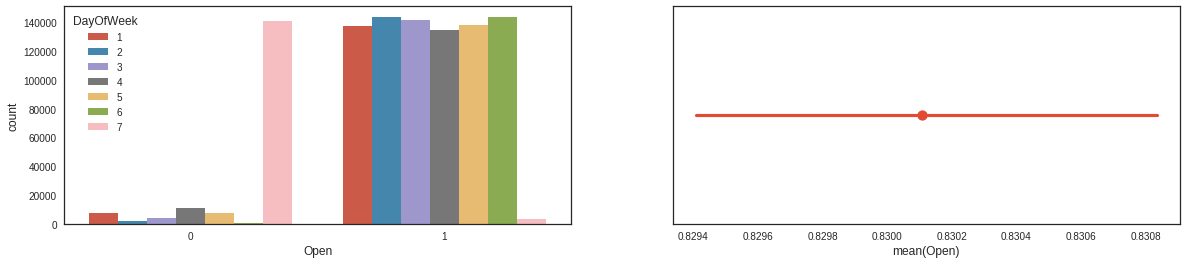

In [19]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(20,4))
sns.countplot(x='Open',hue='DayOfWeek', data=df, ax=axis1)
sns.pointplot(x='Open',hue='DayOfWeek', data=df, ax=axis2)

**The store is mainly closed on day 7 which is Sunday**

In [20]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [0]:
def extract1(x):
    return int(str(x)[:4])

def extract2(x):
    return int(str(x)[5:7])

def extract3(x):
    return (str(x)[:7])

In [0]:
df['Date'] = df['Date'].apply(extract3)
test['Date'] = test['Date'].apply(extract3)
df['Year']  = df['Date'].apply(extract1)
df['Month'] = df['Date'].apply(extract2)
test['Year']  = test['Date'].apply(extract1)
test['Month'] = test['Date'].apply(extract2)
avgsales    = df.groupby('Date')["Sales"].mean()
percentchngsales = df.groupby('Date')["Sales"].sum().pct_change()

**Separating (year + month) in the Date attribute**
AND
**Year and Month also in separate column**

**Extracting month and year feature from the date**

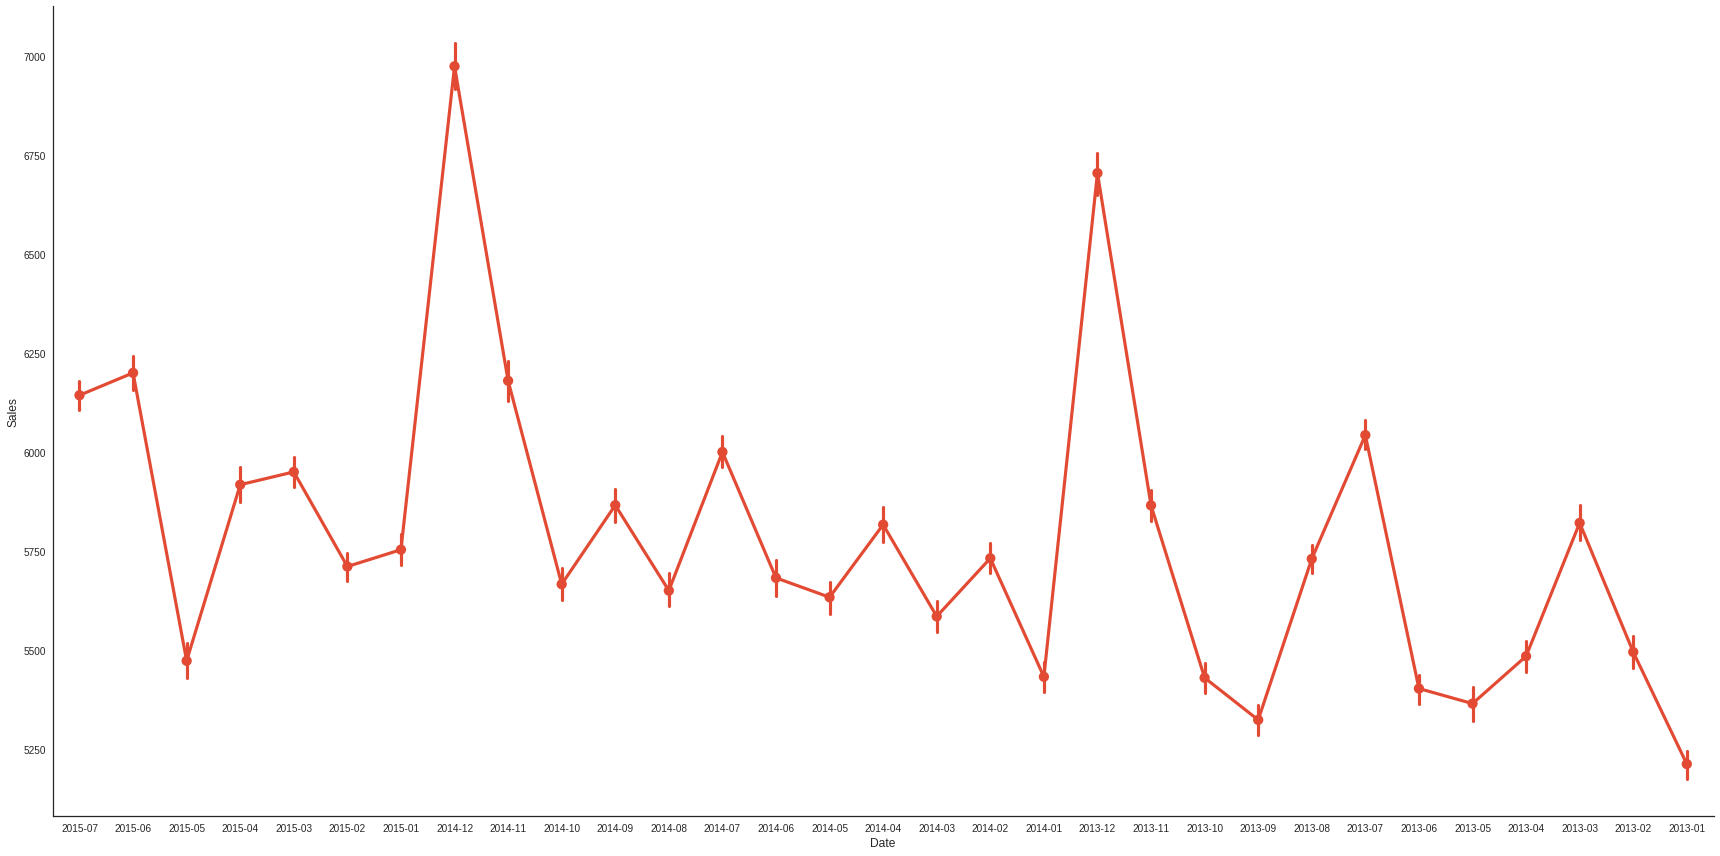

In [23]:
sns.factorplot(x="Date" ,y = "Sales" , data=df, kind="point", aspect=2,size=12)

**Heat-Map to show correlation b/w numerical attributes**

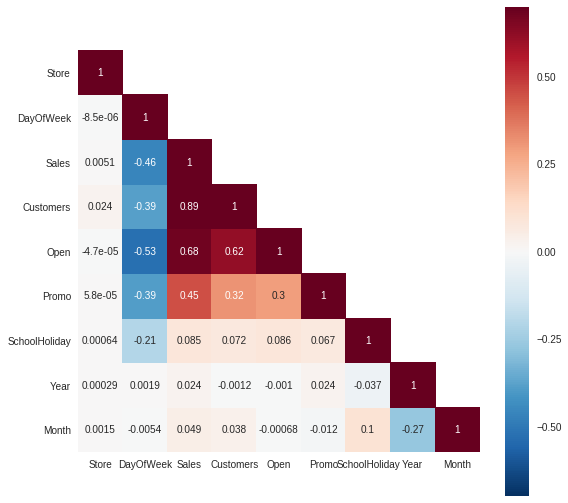

In [24]:
correlation_map = df[df.columns].corr()
obj = np.array(correlation_map)
obj[np.tril_indices_from(obj)] = False
fig,ax= plt.subplots()
fig.set_size_inches(9,9)
sns.heatmap(correlation_map, mask=obj,vmax=.7, square=True,annot=True)

In [0]:
def plotter(StringA , StringB):
  fig, axes = plt.subplots(2,1)
  fig.set_size_inches(15, 10)
  sns.barplot(x=StringA, y=StringB, data=df ,hue="DayOfWeek", ax = axes[0])
  sns.boxplot(x=StringA, y=StringB, data=df ,hue="DayOfWeek", ax=axes[1])

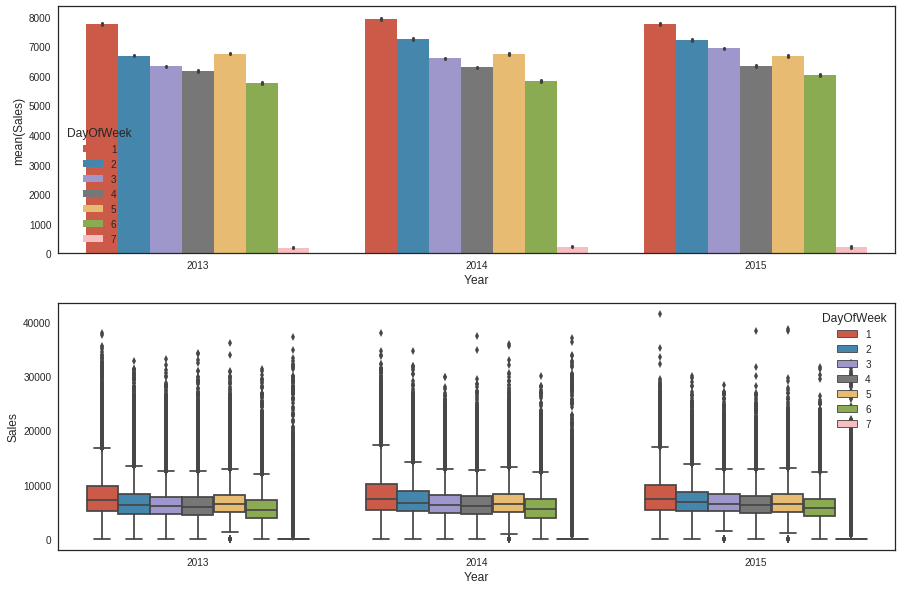

In [26]:
plotter("Year" , "Sales")

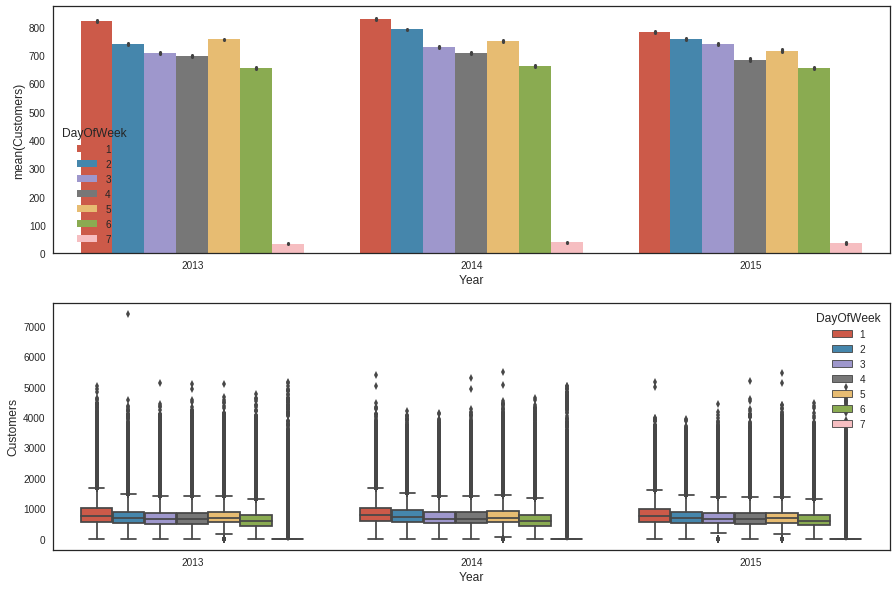

In [27]:
plotter("Year" , "Customers")

**Encoding Stateholiday similarly**

In [0]:
df["StateHoliday"] = df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
test["StateHoliday"] = test["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

In [29]:
df.StateHoliday.value_counts()

0    986159
1     31050
Name: StateHoliday, dtype: int64

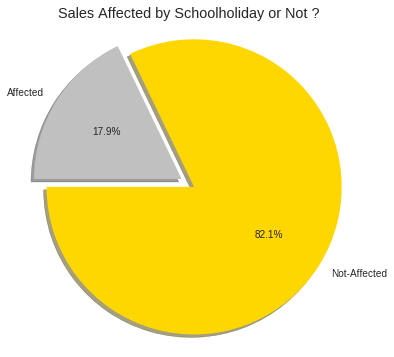

In [30]:
labels = 'Not-Affected' , 'Affected'
sizes = df.SchoolHoliday.value_counts()
colors = ['gold', 'silver']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by Schoolholiday or Not ?")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

In [31]:
df.SchoolHoliday.value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

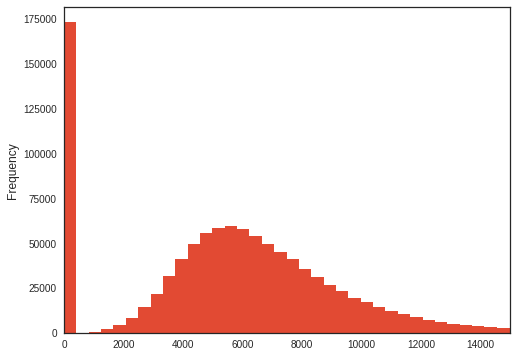

In [32]:
df["Sales"].plot(kind='hist',bins=100,xlim=(0,15000))

**0 is raised because most of the times store was closed**

In [33]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [0]:
temp = []
for i in df.groupby('Store')[["Sales", "Customers"]].mean()["Sales"]:
  temp.append(i)
store["Sales"] = temp

In [0]:
temp = []
for i in df.groupby('Store')[["Sales", "Customers"]].mean()["Customers"]:
  temp.append(i)
store["Customers"] = temp

In [36]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,Customers
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3945.704883,467.646497
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",4122.991507,486.045648
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",5741.253715,620.286624
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,8021.769639,1100.057325
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,3867.110403,444.360934


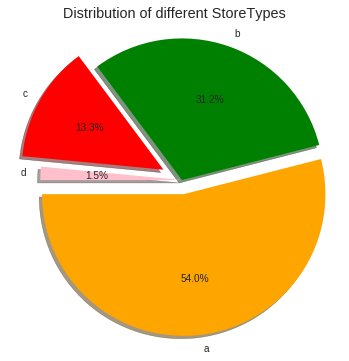

In [37]:
labels = 'a' , 'b' , 'c' , 'd'
sizes = store.StoreType.value_counts()
colors = ['orange', 'green' , 'red' , 'pink']
explode = (0.1, 0.0 , 0.15 , 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Distribution of different StoreTypes")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

In [0]:
def plotmaster(StringA , StringB):
  fig, axes = plt.subplots(3,1)
  fig.set_size_inches(12, 15)
  sns.barplot(x=StringA, y=StringB, data=store ,hue="StoreType", ax = axes[0])
  sns.boxplot(x=StringA, y=StringB, data=store ,hue="StoreType", ax=axes[1])
  sns.violinplot(x=StringA, y=StringB, data=store, hue="StoreType" , ax=axes[2])

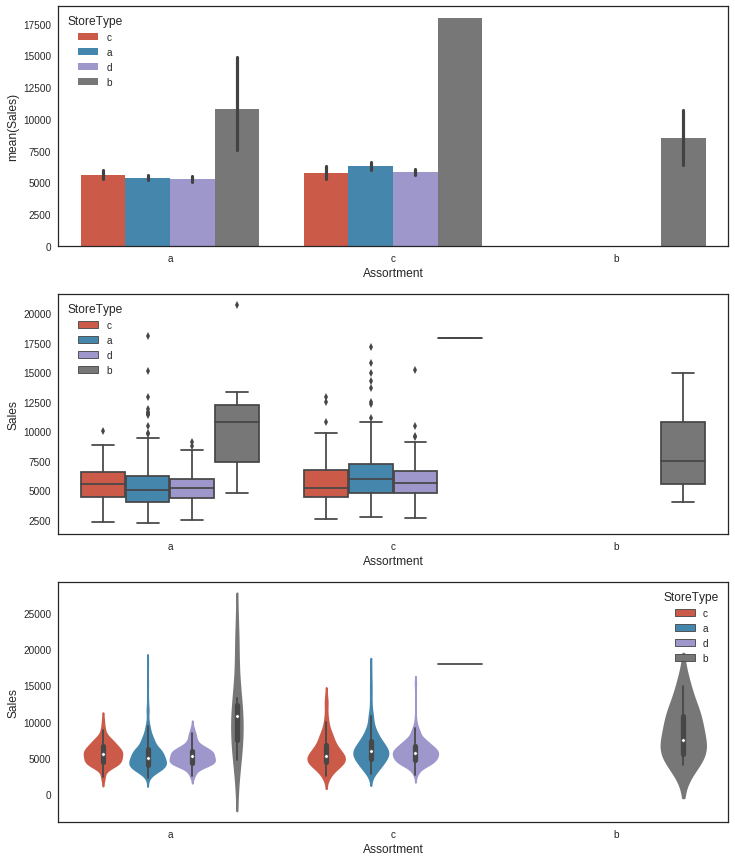

In [39]:
plotmaster("Assortment" , "Sales")

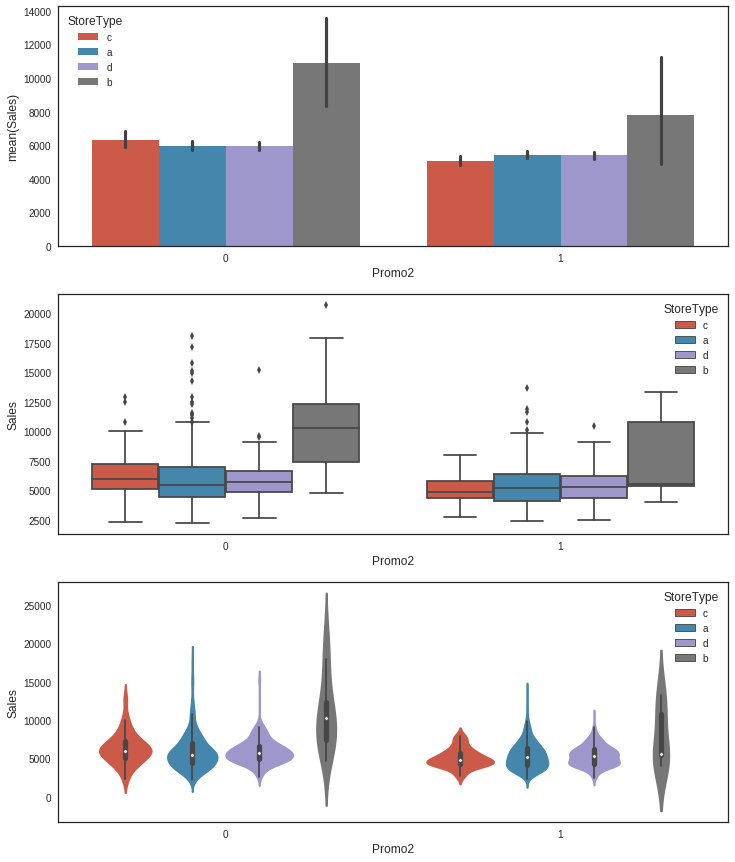

In [40]:
plotmaster("Promo2" , "Sales")

In [41]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
Sales                          0
Customers                      0
dtype: int64

**stores which are opened on Sundays **

In [42]:
df[(df.Open == 1) & (df.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877])

In [43]:
from google.colab import files
uploaded = files.upload()

Saving store.csv to store (1).csv


In [0]:
store = pd.read_csv(io.StringIO(uploaded['store.csv'].decode('utf-8')))

In [45]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [0]:
test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))

In [0]:
df = new.copy()

In [0]:
test.fillna(1, inplace=True)
df = df[df["Open"] != 0]
df = df[df["Sales"] > 0]
df['log_sales'] = np.log(df['Sales'])
df = pd.merge(df, store, on='Store')
test = pd.merge(test, store, on='Store')
df.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [0]:
df["StateHoliday"] = df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
test["StateHoliday"] = test["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
df['StateHoliday'] = df['StateHoliday'].astype(float)
test['StateHoliday'] = test['StateHoliday'].astype(float)

In [50]:
new.head().Date

0    2015-07-31
1    2015-07-31
2    2015-07-31
3    2015-07-31
4    2015-07-31
Name: Date, dtype: object

**Again extracting day , month and year**

In [0]:
df["year"]=df.Date.apply(extract1)
df["month"]=df.Date.apply(extract2)

In [0]:
df["Day"]=df.Date.apply(lambda x: int(str(x)[8:10]))

In [0]:
test["year"]=test.Date.apply(extract1)
test["month"]=test.Date.apply(extract2)
test["Day"]=test.Date.apply(lambda x: int(str(x)[8:10]))

**Now getting dummies**

In [0]:
df = pd.get_dummies(df,columns=['StoreType','Assortment','year'])
test = pd.get_dummies(test,columns=['StoreType','Assortment','year'])
test['year_2013']=0
test['year_2014']=0

In [0]:
X = df.drop(['Sales','log_sales','Store','Date','Customers','CompetitionOpenSinceYear','Promo2SinceYear','PromoInterval'] , axis = 1)
y = df['log_sales']

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=7)
X_test = test.drop(['Id','Store','Date' ,'CompetitionOpenSinceYear','Promo2SinceYear','PromoInterval'] , axis = 1)

In [0]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train , y_train)
pred = reg.predict(X_val)

In [26]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val,pred))
print(rmse)

0.3731435568682413


## Note : 
## All the grid searchs are performed piecewise and looked for locally best parameters and thereafter shifted to the new parameters accordingly to make it computationally less expensive .

In [59]:
from sklearn.model_selection import GridSearchCV
model = linear_model.Ridge(random_state = 1)

param_grid = {
"alpha" : [0.01 , 0.2 , 0.250 , 0.3] 
}
grid = GridSearchCV( model , param_grid , cv = 7 , scoring = "neg_mean_squared_error")
grid.fit(X,y)

GridSearchCV(cv=7, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01, 0.2, 0.25, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [60]:
grid.best_score_

-0.14055928229964268

In [61]:
rmse = np.sqrt(-grid.best_score_)
print(rmse)

0.374912366159937


**Even after repeated PIECE WISE gridsearchCV the min RMSE is 0.3749 which is still greater than linear regression using Ordinary Least Squares**

In [62]:
grid.best_params_

{'alpha': 0.3}

In [63]:
model = linear_model.Lasso(random_state = 1)

param_grid = {
"alpha" : [0.001 , 0.0001] ,
"max_iter" : [600 , 700]
}
grid = GridSearchCV( model , param_grid , cv = 7 , scoring = "neg_mean_squared_error")
grid.fit(X,y)

GridSearchCV(cv=7, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.0001], 'max_iter': [600, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

**Though alpha is checked for 10^-4 learning rate which is very low and very slow to train but the initial piece-wise checkings with LASSO favoured low learning rates so we have to check them .**

In [64]:
grid.best_score_

-0.14029851746942404

In [65]:
rmse = np.sqrt(-grid.best_score_)
print(rmse)

0.3745644370057361


In [66]:
grid.best_params_

{'alpha': 0.001, 'max_iter': 600}

**The result is slightly impressive than Ridge but still slightly worse than ordinary sqaures one for the best_params_ as evaluated**



In [0]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf.fit(X_train , y_train)
pred = clf.predict(X_val)

In [68]:
rmse = np.sqrt(mean_squared_error(y_val,pred))
print(rmse)

0.1816812533849651


**Without parameter tuning the decision tree regressor is giving 0.1816 as RMSE which is quite good in comparison with Lasso , Ridge , etc.  But above training was not cross-validated as Lasso and Ridge were. **

# Ensemble Techniques

In [0]:
rf = RandomForestRegressor(n_estimators=100,max_depth=15)

rf.fit(X_train,y_train)

rf_pred = rf.predict(X_val)

In [77]:
rmse_rf = np.sqrt(mean_squared_error(y_val,rf_pred))
rmse_rf

0.2369510410778777

## The parameters in the XGBRegressor have been tuned and only showed one of the best here.

In [78]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
xgb.fit(X_train,y_train)
xg_pred = xgb.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val,xg_pred))
rmse_xgb

0.10874770925687922

## XGBoost Regressor achieved a considerably low RMSE of 0.10874 and did really well in this case.

In [79]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
scores = cross_val_score(xgb, X , y , cv=5)
scores

array([0.20393952, 0.18654701, 0.12733057, 0.1883136 , 0.18449478])

## Cross validations upto 5 also yielded a minimum of 0.1273  which is less than any other model's RMSE. 

**Now training on full data and predicting using new trained model**

In [28]:
from xgboost import XGBRegressor
xgb_final = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
xgb_final.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=None, n_estimators=120,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

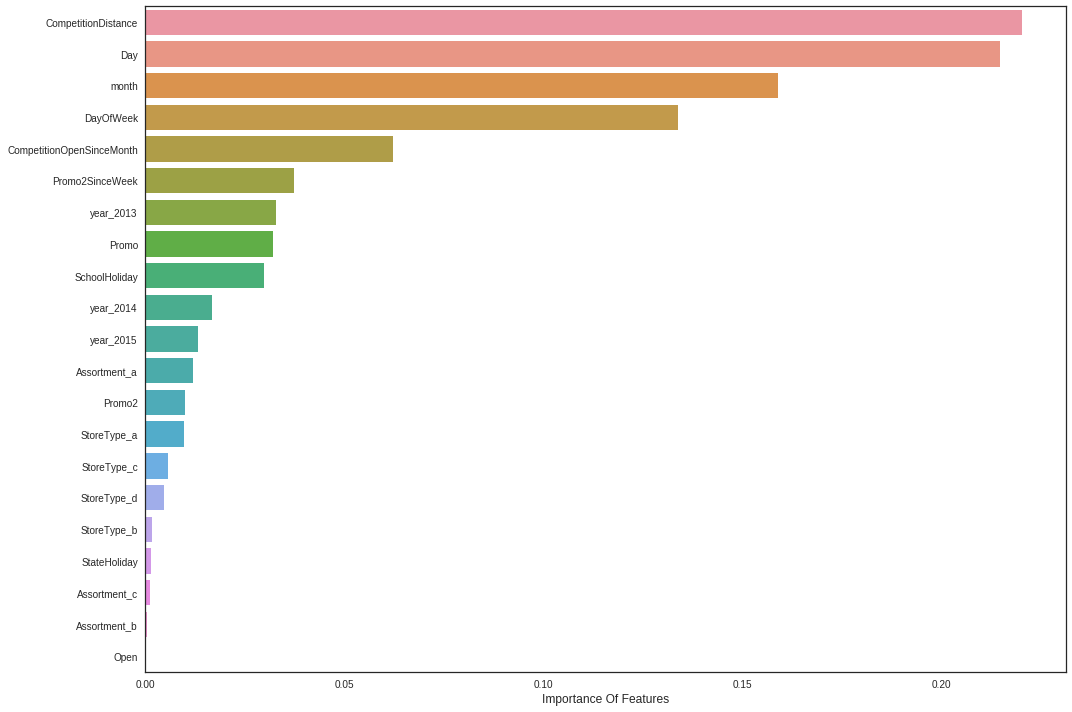

In [29]:
ranks = np.argsort(-xgb_final.feature_importances_)
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x=xgb_final.feature_importances_[ranks], y=X_train.columns.values[ranks], orient='h')
ax.set_xlabel("Importance Of Features")
plt.tight_layout()
plt.show()

In [0]:
X_Test = X_test.copy()

In [0]:
a = X_test["year_2015"]

In [0]:
X_test.drop("year_2015" , axis = 1 , inplace = True)

In [0]:
X_test["year_2015"] = a

In [38]:
X_test.columns

Index(['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'Promo2',
       'Promo2SinceWeek', 'month', 'Day', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'year_2013', 'year_2014', 'year_2015'],
      dtype='object')

In [0]:
final_predictions = xgb_final.predict(X_test)

In [0]:
dic = {
    'Id':test['Id'].astype(int),
    'Sales': np.exp(final_predictions)
}

xgb_sub = pd.DataFrame(dic ,columns=['Id','Sales'])

In [42]:
xgb_sub.head()

,Id,Sales
0,1,5929.072266
1,857,6238.463379
2,1713,6792.575684
3,2569,7864.563477
4,3425,5942.227539


In [0]:
result = xgb_sub.sort_values(by='Id',ascending=True)
result.to_csv('result.csv',index=False)

In [44]:
result.head()

,Id,Sales
0,1,5929.072266
48,2,7433.999512
96,3,9117.695312
144,4,6707.481934
192,5,7239.656738


In [0]:
from google.colab import files
files.download('result.csv')